# What's the Best Neighborhood for you?

In [1]:
#install and import needed libraries
!pip install geocoder
!pip install folium

import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print("Everything has been installed/imported")

Everything has been installed/imported


### Extract the data

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extract_data = requests.get(url).text
wiki_info = BeautifulSoup(extract_data, 'lxml')
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_info.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0
for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            postcode = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td.text
            borough = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
        
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [3]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M5M,North York,Downsview
freq,1,24,4


In [5]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [6]:

postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892
5,M1J,Scarborough,Scarborough Village,43.74446,-79.23117
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72582,-79.26461
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71289,-79.28506
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69510,-79.26466


In [7]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="my_application")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('Co-ordinates of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

Co-ordinates of Scarborough,Toronto are 43.7729744, -79.2576479.


### Map of the area

In [9]:
map_S = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)
for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_S)  
map_S

In [10]:

# @hiddel_cell
CLIENT_ID = 'ZMQEANJCYMC3W2UMKUAWJ4JNGI5RWJM1HV4LSCFJRUXQILTP' # my Foursquare ID
CLIENT_SECRET = 'OLPLOQEGDGWQ515H3MYSSQEASCDIEI4MI4EHN5CSLGBPFI4R' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZMQEANJCYMC3W2UMKUAWJ4JNGI5RWJM1HV4LSCFJRUXQILTP
CLIENT_SECRET: OLPLOQEGDGWQ515H3MYSSQEASCDIEI4MI4EHN5CSLGBPFI4R


In [11]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="my_application")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()
venues=results['response']['groups'][0]['items']
nearby_loc = json_normalize(venues)
nearby_loc.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Venues in the area and their categories

In [13]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_loc = nearby_loc.loc[:, filtered_columns]
nearby_loc.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
3,Coliseum Scarborough Cinemas,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",43.775995,-79.255649
4,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369


In [15]:
a=pd.Series(nearby_loc.categories)
a.value_counts()[:10]

Clothing Store        7
Coffee Shop           3
Pharmacy              2
Sandwich Place        2
Department Store      2
Restaurant            2
Luggage Store         1
Fish & Chips Shop     1
Dim Sum Restaurant    1
Frozen Yogurt Shop    1
Name: categories, dtype: int64

In [20]:
def getNearbyLoc(names, latitudes, longitudes, radius=700):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_loc = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_loc.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_loc)
Scar_venues = getNearbyLoc(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [21]:
print('{} Uniques Categories.'.format(len(Scar_venues['Venue Category'].unique())))

307 Uniques Categories.


### Common venues near each neighborhood

In [29]:
Scar_onehot = pd.get_dummies(Scar_venues[['Venue Category']], prefix="", prefix_sep="")
Scar_onehot['Neighborhood'] = Scar_venues['Neighborhood'] 

fixed_columns = [Scar_onehot.columns[-1]] + list(Scar_onehot.columns[:-1])
Scar_onehot = Scar_onehot[fixed_columns]
Scar_grouped = Scar_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5
for neighbor in Scar_grouped['Neighborhood']:
    print(" * "+neighbor+" * ")
    temp =Scar_grouped[Scar_grouped['Neighborhood'] == neighbor].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

 * Agincourt * 
                venue  freq
0  Chinese Restaurant  0.10
1       Shopping Mall  0.10
2            Pharmacy  0.05
3      Sandwich Place  0.05
4                Bank  0.05


 * Alderwood, Long Branch * 
            venue  freq
0        Pharmacy  0.14
1     Gas Station  0.14
2             Pub  0.14
3  Sandwich Place  0.14
4     Pizza Place  0.14


 * Bathurst Manor, Wilson Heights, Downsview North * 
                       venue  freq
0                       Park  0.13
1                Coffee Shop  0.13
2          Convenience Store  0.07
3                 Restaurant  0.07
4  Middle Eastern Restaurant  0.07


 * Bayview Village * 
              venue  freq
0       Flower Shop  0.17
1  Asian Restaurant  0.17
2           Dog Run  0.17
3             Trail  0.17
4              Park  0.17


 * Bedford Park, Lawrence Manor East * 
                venue  freq
0      Sandwich Place  0.08
1  Italian Restaurant  0.08
2         Coffee Shop  0.08
3                 Pub  0.04
4            

In [32]:
def return_most_common(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_loc_sorted = pd.DataFrame(columns=columns)
neighborhoods_loc_sorted['Neighborhood'] = Scar_grouped['Neighborhood']

for ind in np.arange(Scar_grouped.shape[0]):
    neighborhoods_loc_sorted.iloc[ind, 1:] = return_most_common(Scar_grouped.iloc[ind, :], num_top_venues)

neighborhoods_loc_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Hong Kong Restaurant,Sandwich Place,Sushi Restaurant,Supermarket,Latin American Restaurant,Pharmacy,Bubble Tea Shop,Newsagent
1,"Alderwood, Long Branch",Gas Station,Sandwich Place,Pizza Place,Pub,Pharmacy,Coffee Shop,Gym,Eastern European Restaurant,Distribution Center,Dive Bar
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Park,Mediterranean Restaurant,Fried Chicken Joint,Convenience Store,Restaurant,Deli / Bodega,Sandwich Place,Middle Eastern Restaurant,Men's Store
3,Bayview Village,Dog Run,Flower Shop,Gas Station,Trail,Park,Asian Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pet Store,Juice Bar,Restaurant,Sports Club,Thai Restaurant,Intersection,Pub


### K-Means

In [34]:
Scar_grouped_clustering = Scar_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scar_grouped_clustering)
neighborhoods_loc_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scar_merged =df_2.iloc[:16,:]
Scar_merged = Scar_merged.join(neighborhoods_loc_sorted.set_index('Neighborhood'), on='Neighborhood')
Scar_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,0,Zoo Exhibit,Construction & Landscaping,Fast Food Restaurant,Paintball Field,Escape Room,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,1,Bar,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,2,Park,Gym / Fitness Center,Athletics & Sports,Gymnastics Gym,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
3,M1G,Scarborough,Woburn,43.76812,-79.21761,2,Fast Food Restaurant,Chinese Restaurant,Park,Coffee Shop,Yoga Studio,Elementary School,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,0,Bakery,Bank,Caribbean Restaurant,Gas Station,Athletics & Sports,Hakka Restaurant,Thai Restaurant,Electronics Store,Doner Restaurant,Donut Shop


### Mapping of the clusters

In [36]:
kclusters = 10
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
markers_colors = []
for lat, lon, nei , cluster in zip(Scar_merged['Latitude'], 
                                   Scar_merged['Longitude'], 
                                   Scar_merged['Neighborhood'], 
                                   Scar_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


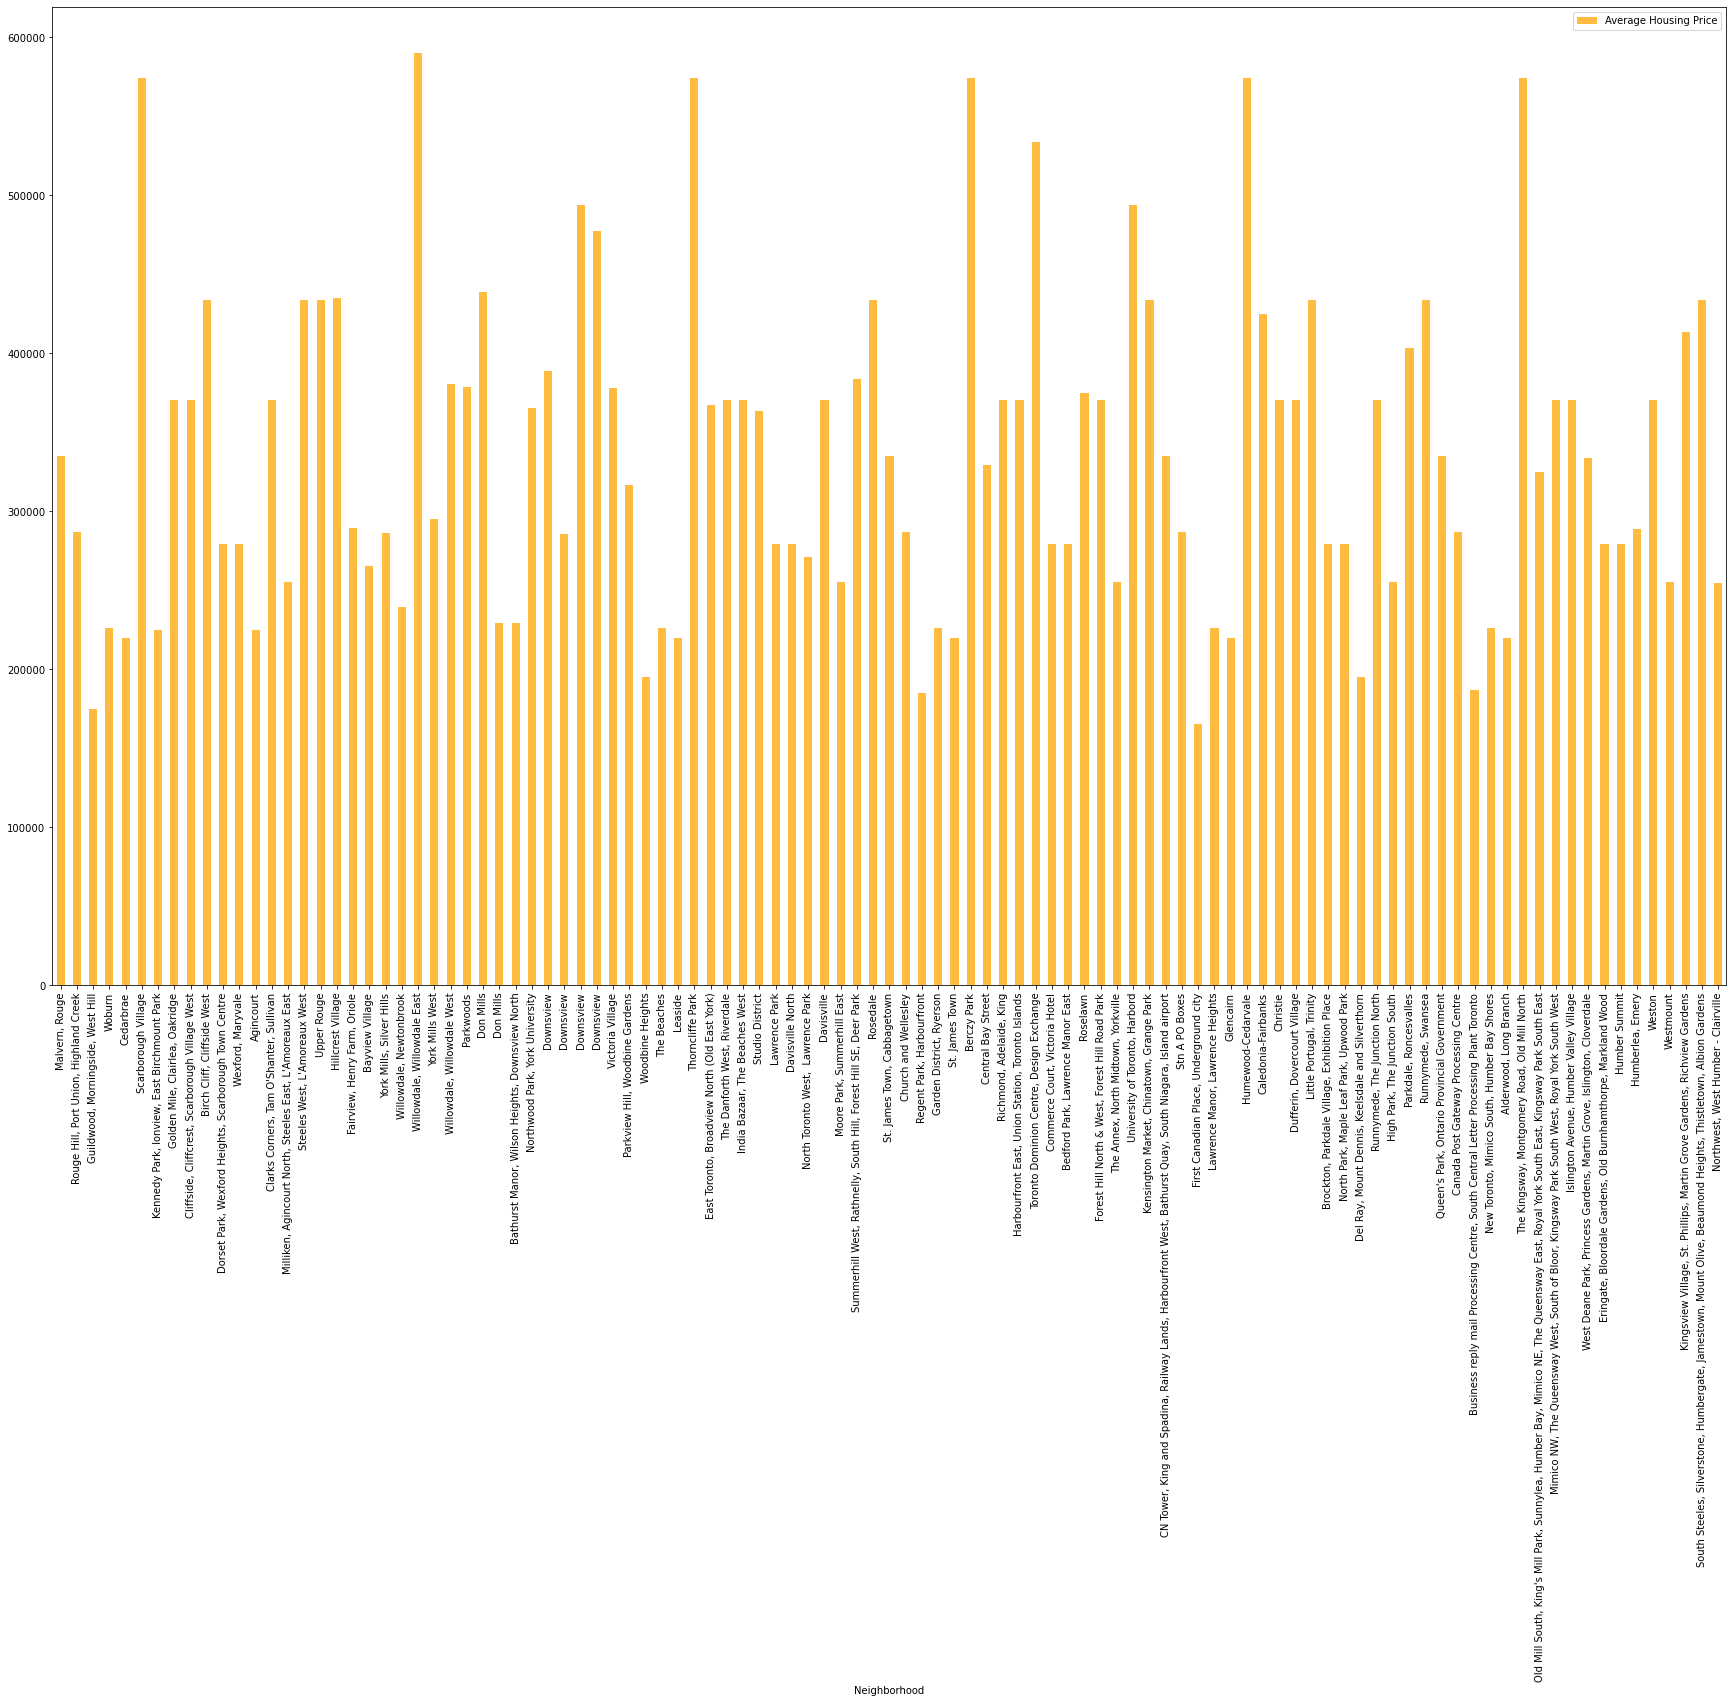

In [46]:
df1=Scar_merged.loc[Scar_merged['Cluster Labels'] == 0,Scar_merged.columns[[2] + list(range(5, Scar_merged.shape[1]))]]
df2=Scar_merged.loc[Scar_merged['Cluster Labels'] == 1,Scar_merged.columns[[2] + list(range(5, Scar_merged.shape[1]))]]
df3=Scar_merged.loc[Scar_merged['Cluster Labels'] == 2,Scar_merged.columns[[2] + list(range(5, Scar_merged.shape[1]))]]
Scar_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average Housing Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})
Scar_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scar_Avg_HousingPrice.plot(kind='bar',figsize=(30,18),color='orange',alpha=0.75)

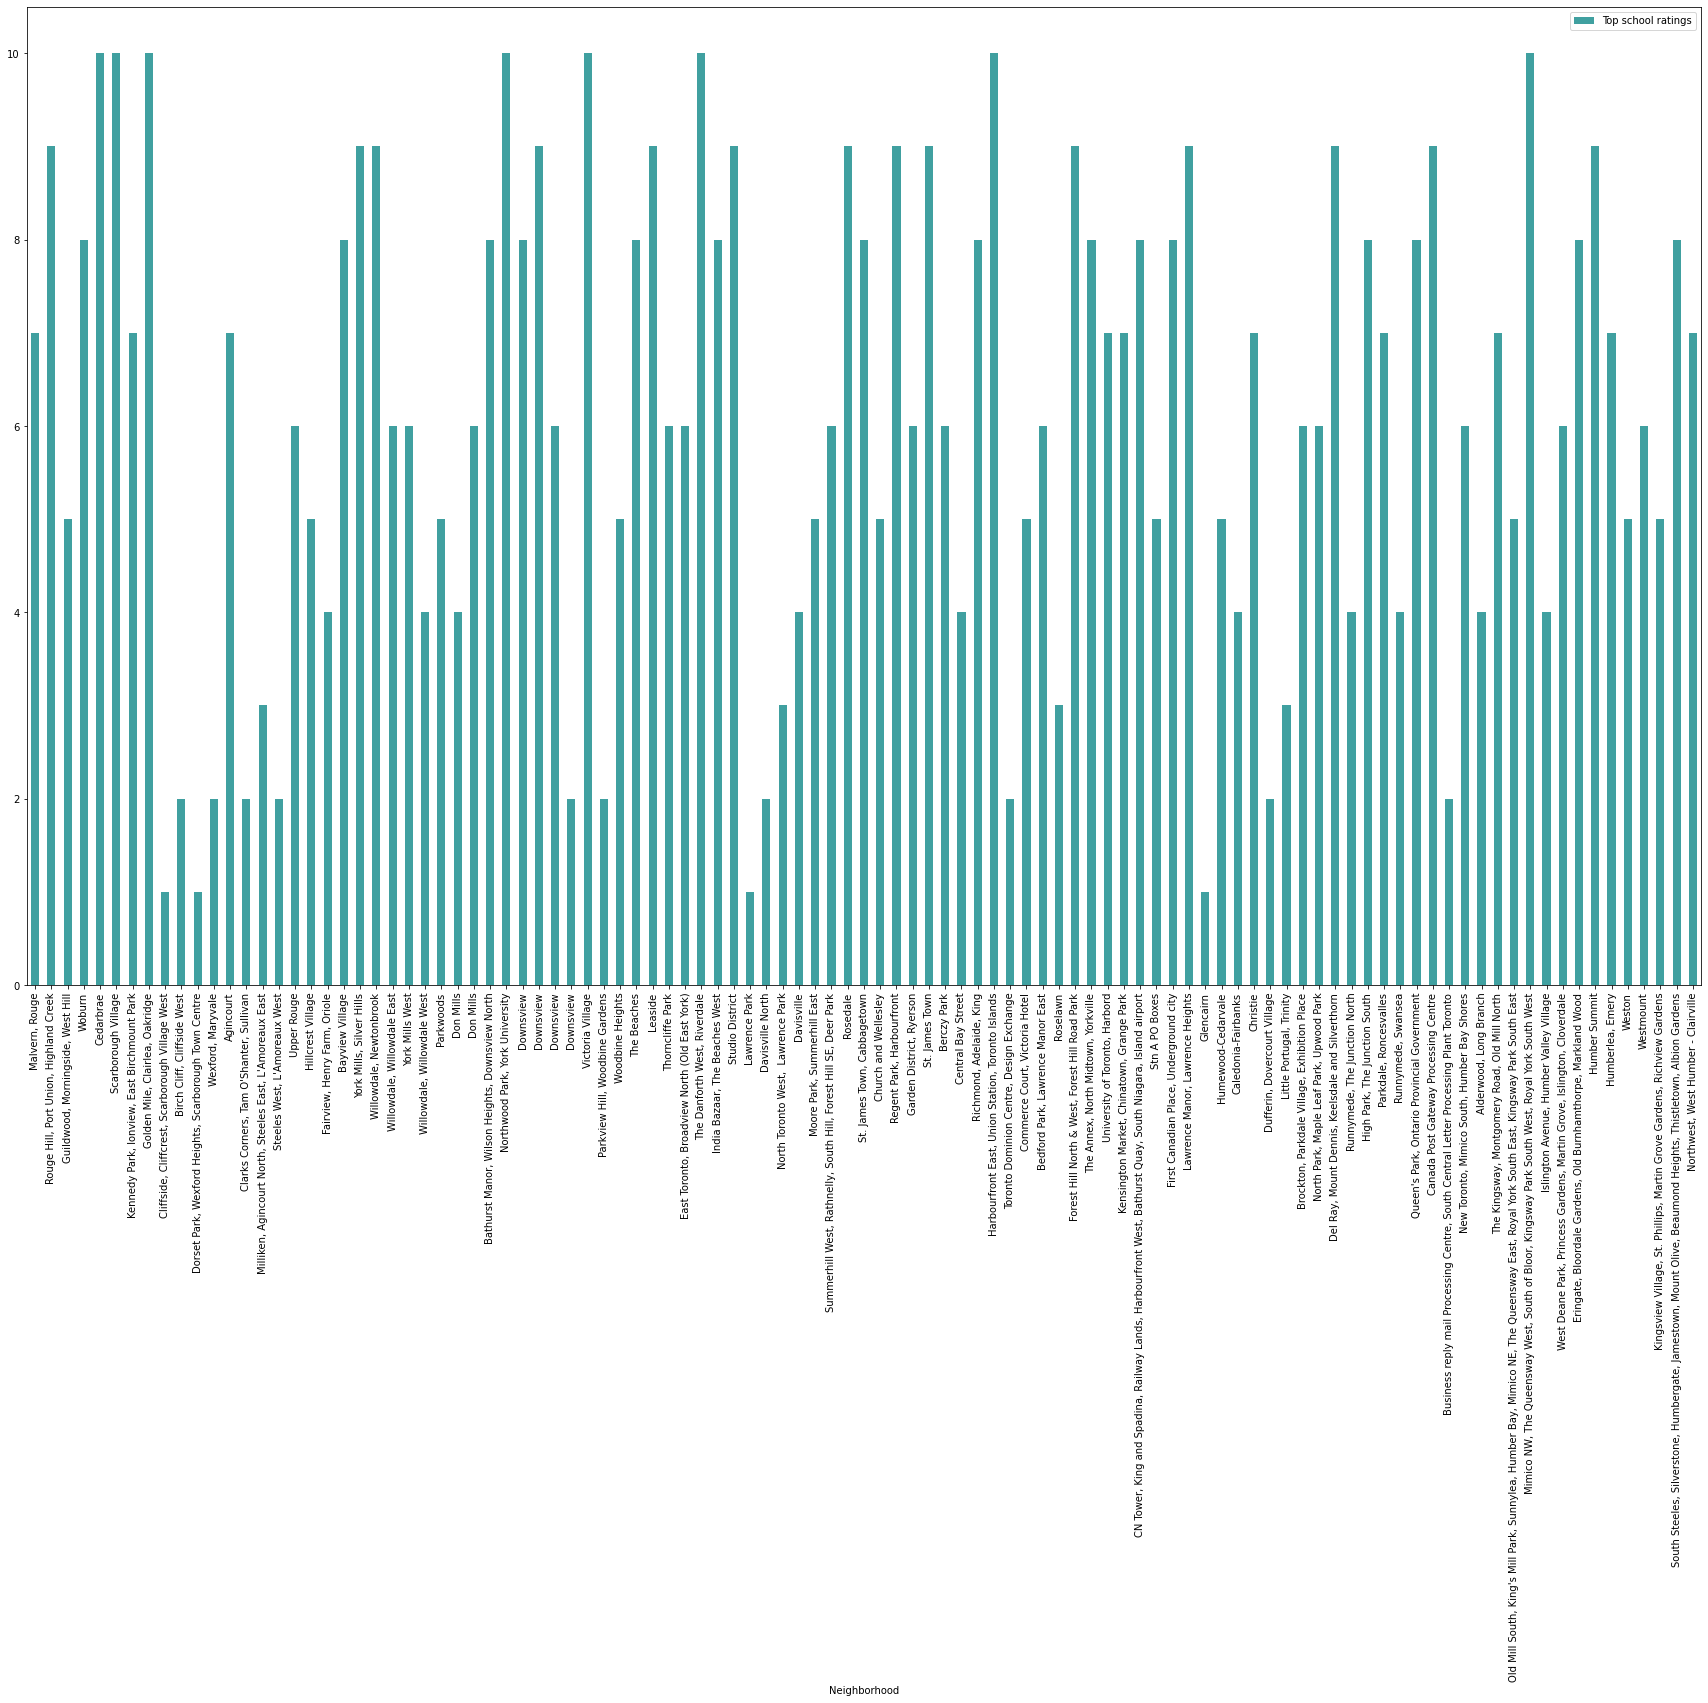

In [45]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)
new_Scar=Scar_merged.set_index("Neighborhood",drop=True)
Scar_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top school ratings":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})
Scar_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scar_school_ratings.plot(kind='bar',figsize=(30,18),color='teal',alpha=0.75);

The charts above when presented to a user will show the average home prices and the school ratings for the area.